### Install Initial Dependencies

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

### Load Dataset

This dataset contains over 8600 rows of data, on each row is a person’s:
- Type (This persons 4 letter MBTI code/type)
- A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))

The dataset was taken from Kaggle, but the data itself was collected through the PersonalityCafe forum (http://personalitycafe.com/forum/). The purpose of this dataset is to help see if any patterns can be detected in specific types and their style of writing.

In [13]:
import os

CSV_DATA_PATH = os.path.join("data", "mbti_1.csv")

def load_csv_data(csv_file_path: str = CSV_DATA_PATH) -> pd.DataFrame:
    """ Load data from a given csv file into a pandas DataFrame object.

    Args:
    - csv_file_path (str) - The file path of the csv file containing the desired data to load into a pandas DataFrame object.

    Returns:
    - data (pandas.DataFrame) - The loaded data as a pandas DataFrame object.
    """
    assert csv_file_path.endswith(".csv")

    return pd.read_csv(csv_file_path)

In [14]:
data = load_csv_data()
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [16]:
# Quick check for duplicated rows
duplication_bool_series = data.duplicated()
duplication_bool_series.sum()

0

##### Data Wrangling

In [17]:
from itertools import zip_longest

def get_online_posts_df(df: pd.DataFrame, type_col: str = "type", posts_col: str = "posts") -> pd.DataFrame:
    """ Takes in an input pandas DataFrame, each row having a (user_personality_type, user_recent_50_comments) schema and user_recent_50_comments is a '|||' delimited string.
    Outputs a DataFrame object where each row is a (user_personality_type, user_comment), where each row no contains exactly one comment.

    Args:
    - df (pandas.DataFrame) - The input pandas DataFrame object, where each row follows the schema (user_personality_type, user_recent_50_comments).
    - type_col (str) - The column name of the input DataFrame's personality type column, which contains the user's personality type.
    - posts_col (str) - The column name of the input DataFrame's posts column, which contains the user's recent 50 comments/online posts

    Returns:
    - output_df (pandas.DataFrame) - The output pandas DataFrame object, where each row follows the schema (user_personality_type, user_comment).
    """
    online_posts_dict = {
        type_col: [],
        posts_col: []
    }

    for index, row in df.iterrows():
        personality_type = row[type_col]
        recent_50_comments = row[posts_col].split("|||")

        online_posts_dict[type_col] += [personality_type] * len(recent_50_comments)
        online_posts_dict[posts_col] += recent_50_comments

    columns = online_posts_dict.keys()
    values = list(zip_longest(*online_posts_dict.values()))
    output_df = pd.DataFrame(values, columns=columns)

    return output_df

In [18]:
online_posts_df = get_online_posts_df(data)
online_posts_df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,INFJ,enfp and intj moments https://www.youtube.com...
3,INFJ,What has been the most life-changing experienc...
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


##### Feature Engineering
Since there are only two features in the given dataset (type and posts), some additional features will be engineered from the post feature's data in order to see if there is any additional insights to be gained from the data that we have.

NOTE: If the "data/mbti_2.csv" already exists, the below code cells for the Feature Engineering section do not need to be run as there is already a local csv file that contains the newly engineered features that you can use in subsequent sections. 

In [19]:
# Set up nltk for work token processing.
import nltk
nltk.download(["popular", "vader_lexicon"])

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]   

True

##### Feature Engineering - URL Count

In [20]:
import re

def extract_url_count_from_posts(df: pd.DataFrame, posts_col: str = "posts") -> pd.DataFrame:
    """ Given an input pandas DataFrame that contains a column with user online posts, extract any URLs within each post.

    Args:
    - df (pandas.DataFrame) - The input DataFrame object.
    - posts_col (str) - The name of the DataFrame column that contains the user online posts.

    Returns:
    - df (pandas.DataFrame) - The DataFrame object which contains a new column where each row contains the frequency that a URL has been mentioned for that index.
    """
    regex_pattern = r"((?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’])))"
    
    df["url_count"] = df[posts_col].apply(lambda x: re.findall(regex_pattern, x)).str.len()

    return df

In [21]:
online_posts_df = extract_url_count_from_posts(online_posts_df)
online_posts_df.head()

,type,posts,url_count
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,1
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,1
2,INFJ,enfp and intj moments https://www.youtube.com...,2
3,INFJ,What has been the most life-changing experienc...,0
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,2


In [22]:
online_posts_df["posts"].iloc[2]

'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks'

In [23]:
online_posts_df.tail()

,type,posts,url_count
422840,INFP,I was going to close my facebook a few months ...,0
422841,INFP,30 Seconds to Mars - All of my collections. It...,0
422842,INFP,"I have seen it, and i agree. I did actually th...",0
422843,INFP,Ok so i have just watched Underworld 4 (Awaken...,0
422844,INFP,I would never want to turn off my emotions. so...,0


##### Feature Engineering - Noun, Verb, Adjective, Adverb, and other POS frequencies per comment/post

In [24]:
def get_online_posts_no_urls(df: pd.DataFrame, posts_col: str = "posts") -> pd.DataFrame:
    """ Given an input pandas DataFrame that contains a column with user online posts, extract only non-url text from each post.

    Args:
    - df (pandas.DataFrame) - The input DataFrame object.
    - posts_col (str) - The name of the DataFrame column that contains the user online posts.

    Returns:
    - df (pandas.DataFrame) - The DataFrame object which contains a new column where each row contains the online post without any URLs
    """
    regex_pattern = r"((?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’])))"

    df["posts_no_url"] = df[posts_col].str.replace(regex_pattern, "").str.strip()

    return df

In [25]:
online_posts_df = get_online_posts_no_urls(online_posts_df)
online_posts_df.head()

C:\Users\stefa\AppData\Local\Temp\ipykernel_11564\1188810670.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df["posts_no_url"] = df[posts_col].str.replace(regex_pattern, "").str.strip()


,type,posts,url_count,posts_no_url
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,1,'
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,1,
2,INFJ,enfp and intj moments https://www.youtube.com...,2,enfp and intj moments sportscenter not top ...
3,INFJ,What has been the most life-changing experienc...,0,What has been the most life-changing experienc...
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,2,On repeat for most of today.


In [26]:
online_posts_df["posts"].iloc[100:105]

100    'Good one  _____   https://www.youtube.com/wat...
101    Of course, to which I say I know; that's my bl...
102    Does being absolutely positive that you and yo...
103                  No, I didn't; thank you for a link!
104    So-called Ti-Si loop (and it can stem from any...
Name: posts, dtype: object

In [27]:
online_posts_df["posts"].iloc[100]

"'Good one  _____   https://www.youtube.com/watch?v=fHiGbolFFGw"

In [28]:
online_posts_df["posts_no_url"].iloc[100]

"'Good one  _____"

In [29]:
def pos_tag_posts(df: pd.DataFrame, posts_col: str = "posts_no_url") -> pd.DataFrame:
    """ Given an input pandas DataFrame with a column of online posts, perform POS tagging on the posts and return a DataFrame with a column that contains the POS tagged posts.

    Args:
    - df (pandas.DataFrame) - The input DataFrame object.
    - posts_col (str) - The name of the DataFrame column that contains the user online posts.

    Returns:
    - df (pandas.DataFrame) - The DataFrame object which contains a new column where each row contains the online post after POS tagging.
    """
    df["posts_no_url_tokenized"] = df[posts_col].str.lower().apply(nltk.word_tokenize)
    df["posts_no_url_pos_tagged"] = df["posts_no_url_tokenized"].apply(nltk.pos_tag)

    return df

In [30]:
online_posts_df = pos_tag_posts(online_posts_df)
online_posts_df.head()

,type,posts,url_count,posts_no_url,posts_no_url_tokenized,posts_no_url_pos_tagged
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,1,',['],"[(', '')]"
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,1,,[],[]
2,INFJ,enfp and intj moments https://www.youtube.com...,2,enfp and intj moments sportscenter not top ...,"[enfp, and, intj, moments, sportscenter, not, ...","[(enfp, NN), (and, CC), (intj, JJ), (moments, ..."
3,INFJ,What has been the most life-changing experienc...,0,What has been the most life-changing experienc...,"[what, has, been, the, most, life-changing, ex...","[(what, WDT), (has, VBZ), (been, VBN), (the, D..."
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,2,On repeat for most of today.,"[on, repeat, for, most, of, today, .]","[(on, IN), (repeat, NN), (for, IN), (most, JJS..."


In [31]:
online_posts_df["posts_no_url_pos_tagged"].iloc[2]

[('enfp', 'NN'),
 ('and', 'CC'),
 ('intj', 'JJ'),
 ('moments', 'NNS'),
 ('sportscenter', 'MD'),
 ('not', 'RB'),
 ('top', 'VB'),
 ('ten', 'NN'),
 ('plays', 'NNS'),
 ('pranks', 'NNS')]

In [32]:
def add_pos_count_features(df: pd.DataFrame, pos_tagged_tokens_col: str = "posts_no_url_pos_tagged") -> pd.DataFrame:
    """ Given an input pandas DataFrame that contains a column that holds tokenized posts and their POS (part-of-speech tags), add frequency count featured of the following POS tags for each row:
        - Nouns
        - Verbs
        - Cardinal Digits
        - Adjectives
        - Adverbs
        - Prepositions
        - Interjections
        - Determiners

    Args:
    - df (pandas.DataFrame) - the input pandas DataFrame
    - pos_tagged_tokens_col (str) - the name of the column of the input df that holds the pos tagged tokens to use for calculating freqeuncy of a part-of-speech per comment/post/row.

    Returns:
    - df(pandas.DataFrame) - the input pandas DataFrame, but with the newly added features/columns.
    """
    df["noun_freq"] = df[pos_tagged_tokens_col].apply(lambda x: len([word for word, tag in x if tag in ['NN', 'NNS', 'NNP', 'NNPS']]))
    df["verb_freq"] = df[pos_tagged_tokens_col].apply(lambda x: len([word for word, tag in x if tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]))
    df["cardinal_digits_freq"] = df[pos_tagged_tokens_col].apply(lambda x: len([word for word, tag in x if tag in ['CD']]))
    df["adjective_freq"] = df[pos_tagged_tokens_col].apply(lambda x: len([word for word, tag in x if tag in ['JJ', 'JJR', 'JJS']]))
    df["adverb_freq"] = df[pos_tagged_tokens_col].apply(lambda x: len([word for word, tag in x if tag in ['RB', 'RBR', 'RBS', 'WRB']]))
    df["preposition_freq"] = df[pos_tagged_tokens_col].apply(lambda x: len([word for word, tag in x if tag in ['IN']]))
    df["interjection_freq"] = df[pos_tagged_tokens_col].apply(lambda x: len([word for word, tag in x if tag in ['UH']]))
    df["determiner_freq"] = df[pos_tagged_tokens_col].apply(lambda x: len([word for word, tag in x if tag in ['DT', 'WDT']]))

    return df

In [33]:
online_posts_df = add_pos_count_features(online_posts_df)
online_posts_df[["type", "posts", "url_count", "noun_freq", "verb_freq", "cardinal_digits_freq", "adjective_freq", "adverb_freq", "preposition_freq", "interjection_freq", "determiner_freq"]].head()

,type,posts,url_count,noun_freq,verb_freq,cardinal_digits_freq,adjective_freq,adverb_freq,preposition_freq,interjection_freq,determiner_freq
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,1,0,0,0,0,0,0,0,0
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,1,0,0,0,0,0,0,0,0
2,INFJ,enfp and intj moments https://www.youtube.com...,2,5,1,0,1,1,0,0,0
3,INFJ,What has been the most life-changing experienc...,0,2,2,0,1,1,1,0,2
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,2,2,0,0,1,0,3,0,0


In [34]:
online_posts_df[["type", "posts", "url_count", "noun_freq", "verb_freq", "cardinal_digits_freq", "adjective_freq", "adverb_freq", "preposition_freq", "interjection_freq", "determiner_freq"]].tail()

,type,posts,url_count,noun_freq,verb_freq,cardinal_digits_freq,adjective_freq,adverb_freq,preposition_freq,interjection_freq,determiner_freq
422840,INFP,I was going to close my facebook a few months ...,0,9,10,0,4,3,3,0,2
422841,INFP,30 Seconds to Mars - All of my collections. It...,0,3,4,1,0,2,1,0,1
422842,INFP,"I have seen it, and i agree. I did actually th...",0,7,11,0,2,5,3,0,3
422843,INFP,Ok so i have just watched Underworld 4 (Awaken...,0,4,9,2,8,6,3,0,4
422844,INFP,I would never want to turn off my emotions. so...,0,4,4,0,1,3,2,0,1


##### Feature Engineering - Sentiment per comment/post

In [35]:
from nltk.sentiment import SentimentIntensityAnalyzer

def add_sentiment_score_features(df: pd.DataFrame, posts_col: str = "posts") -> pd.DataFrame:
    """ Given an input pandas DataFrame which contains a column that holds online comments posted by users of particular MBTI personality types, add the sentiment scores of those comments as new features to the DataFrame.

    Args:
    - df (pandas.DataFrame) - The input pandas DataFrame object.
    - posts_col (str) - The name of the column that contains the online comments.

    Returns:
    - df (pandas.DataFrame) - The pandas DataFrame object with the newly added sentiment score features.
    """
    sia = SentimentIntensityAnalyzer()
    
    df["negative_sentiment"] = df[posts_col].apply(lambda x: sia.polarity_scores(x)["neg"])
    df["neutral_sentiment"] = df[posts_col].apply(lambda x: sia.polarity_scores(x)["neu"])
    df["positive_sentiment"] = df[posts_col].apply(lambda x: sia.polarity_scores(x)["pos"])
    df["overall_sentiment"] = df[posts_col].apply(lambda x: sia.polarity_scores(x)["compound"])

    return df

In [36]:
online_posts_df = add_sentiment_score_features(online_posts_df)
online_posts_df[[
    "type", 
    "posts", 
    "url_count", 
    "noun_freq", 
    "verb_freq", 
    "cardinal_digits_freq", 
    "adjective_freq", 
    "adverb_freq", 
    "preposition_freq",
    "interjection_freq",
    "determiner_freq",
    "negative_sentiment",
    "neutral_sentiment",
    "positive_sentiment",
    "overall_sentiment"
]].head()

,type,posts,url_count,noun_freq,verb_freq,cardinal_digits_freq,adjective_freq,adverb_freq,preposition_freq,interjection_freq,determiner_freq,negative_sentiment,neutral_sentiment,positive_sentiment,overall_sentiment
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,1,0,0,0,0,0,0,0,0,0.00,1.00,0.0,0.0000
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,1,0,0,0,0,0,0,0,0,0.00,1.00,0.0,0.0000
2,INFJ,enfp and intj moments https://www.youtube.com...,2,5,1,0,1,1,0,0,0,0.27,0.73,0.0,-0.4003
3,INFJ,What has been the most life-changing experienc...,0,2,2,0,1,1,1,0,2,0.00,1.00,0.0,0.0000
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,2,2,0,0,1,0,3,0,0,0.00,1.00,0.0,0.0000


In [37]:
online_posts_df[[
    "type", 
    "posts", 
    "url_count", 
    "noun_freq", 
    "verb_freq", 
    "cardinal_digits_freq", 
    "adjective_freq", 
    "adverb_freq", 
    "preposition_freq",
    "interjection_freq",
    "determiner_freq",
    "negative_sentiment",
    "neutral_sentiment",
    "positive_sentiment",
    "overall_sentiment"
]].tail()

,type,posts,url_count,noun_freq,verb_freq,cardinal_digits_freq,adjective_freq,adverb_freq,preposition_freq,interjection_freq,determiner_freq,negative_sentiment,neutral_sentiment,positive_sentiment,overall_sentiment
422840,INFP,I was going to close my facebook a few months ...,0,9,10,0,4,3,3,0,2,0.00,0.829,0.171,0.7783
422841,INFP,30 Seconds to Mars - All of my collections. It...,0,3,4,1,0,2,1,0,1,0.00,1.000,0.000,0.0000
422842,INFP,"I have seen it, and i agree. I did actually th...",0,7,11,0,2,5,3,0,3,0.00,0.928,0.072,0.3612
422843,INFP,Ok so i have just watched Underworld 4 (Awaken...,0,4,9,2,8,6,3,0,4,0.00,0.798,0.202,0.8218
422844,INFP,I would never want to turn off my emotions. so...,0,4,4,0,1,3,2,0,1,0.12,0.880,0.000,-0.1182


In [38]:
import string

def add_word_count_feature(df: pd.DataFrame, posts_col: str = "posts_no_url_tokenized"):
    """ Given an input pandas DataFrame which contains a column that holds tokenized online comments posted by users of particular MBTI personality types without urls, add the word count for each comment/post.

    Args:
    - df (pandas.DataFrame) - The input pandas DataFrame object.
    - posts_col (str) - The name of the column that contains the tokenized online comments without urls.

    Returns:
    - df (pandas.DataFrame) - The pandas DataFrame object with the newly added sentiment score features.
    """
    df["word_count"] = df[posts_col].apply(lambda x: len([word for word in x if not word in string.punctuation]))

    return df

In [39]:
online_posts_df = add_word_count_feature(online_posts_df)
online_posts_df[[
    "type", 
    "posts", 
    "url_count", 
    "noun_freq", 
    "verb_freq", 
    "cardinal_digits_freq", 
    "adjective_freq", 
    "adverb_freq", 
    "preposition_freq",
    "interjection_freq",
    "determiner_freq",
    "negative_sentiment",
    "neutral_sentiment",
    "positive_sentiment",
    "overall_sentiment",
    "word_count"
]].head()

,type,posts,url_count,noun_freq,verb_freq,cardinal_digits_freq,adjective_freq,adverb_freq,preposition_freq,interjection_freq,determiner_freq,negative_sentiment,neutral_sentiment,positive_sentiment,overall_sentiment,word_count
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,1,0,0,0,0,0,0,0,0,0.00,1.00,0.0,0.0000,0
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,1,0,0,0,0,0,0,0,0,0.00,1.00,0.0,0.0000,0
2,INFJ,enfp and intj moments https://www.youtube.com...,2,5,1,0,1,1,0,0,0,0.27,0.73,0.0,-0.4003,10
3,INFJ,What has been the most life-changing experienc...,0,2,2,0,1,1,1,0,2,0.00,1.00,0.0,0.0000,10
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,2,2,0,0,1,0,3,0,0,0.00,1.00,0.0,0.0000,6


In [40]:
online_posts_df[[
    "type", 
    "posts", 
    "url_count", 
    "noun_freq", 
    "verb_freq", 
    "cardinal_digits_freq", 
    "adjective_freq", 
    "adverb_freq", 
    "preposition_freq",
    "interjection_freq",
    "determiner_freq",
    "negative_sentiment",
    "neutral_sentiment",
    "positive_sentiment",
    "overall_sentiment",
    "word_count"
]].tail()

,type,posts,url_count,noun_freq,verb_freq,cardinal_digits_freq,adjective_freq,adverb_freq,preposition_freq,interjection_freq,determiner_freq,negative_sentiment,neutral_sentiment,positive_sentiment,overall_sentiment,word_count
422840,INFP,I was going to close my facebook a few months ...,0,9,10,0,4,3,3,0,2,0.00,0.829,0.171,0.7783,41
422841,INFP,30 Seconds to Mars - All of my collections. It...,0,3,4,1,0,2,1,0,1,0.00,1.000,0.000,0.0000,17
422842,INFP,"I have seen it, and i agree. I did actually th...",0,7,11,0,2,5,3,0,3,0.00,0.928,0.072,0.3612,39
422843,INFP,Ok so i have just watched Underworld 4 (Awaken...,0,4,9,2,8,6,3,0,4,0.00,0.798,0.202,0.8218,43
422844,INFP,I would never want to turn off my emotions. so...,0,4,4,0,1,3,2,0,1,0.12,0.880,0.000,-0.1182,23


The following new features have been engineered from executing the feature engineering code cells above:
- Number of URLs per comment/post
- Number of nouns per comment/post
- Number of verbs per comment/post
- Number of cardinal digits (mentions of a number) per comment/post
- Number of adjectives per comment/post
- Number of adverbs per comment/post
- Number of prepositions per comment/post
- Number of interjections per comment/post
- Number of determiners per comment/post
- Overall Sentiment Score per comment/post
- Number of words used per comment/post

##### Data Analysis Preparation
Preparation for data analysis by merging the DataFrame with the newly engineered features together with the individual personality factors of each post's author's personality type and writing to a csv file locally. This is done so the above code cells don't have to be run every single time to run the data analysis code cells that will be below.

In [41]:
def get_personality_factors(personality_dataset: pd.DataFrame, personalities_col_name: str = "type") -> dict:
    """ Return a dictionary containing the personality factors from the given pandas DataFrame containing Myers Briggs personalities.

    Args:
    - personality_dataset (pandas.DataFrame) - The pandas DataFrame object containing the Myers Briggs personalities data.
    - personalities_col_name (str) - The name of the column which contains the Myers Briggs personalities in the given DataFrame.

    Returns:
    - personality_factors_dict (dict) - A dictionary containing the number personality factors, split into Extraversion vs Introversion, Sensing vs Intuition, Thinking vs Feeling, Judging vs Perceiving.
    """
    personality_factors_dict = {
        "e_vs_i": [],
        "s_vs_n": [],
        "t_vs_f": [],
        "j_vs_p": []
    }

    for index, row in personality_dataset.iterrows():
        personality_type_str = row[personalities_col_name]
        e_vs_i = personality_type_str[0]
        s_vs_n = personality_type_str[1]
        t_vs_f = personality_type_str[2]
        j_vs_p = personality_type_str[3]

        personality_factors_dict["e_vs_i"].append(e_vs_i)
        personality_factors_dict["s_vs_n"].append(s_vs_n)
        personality_factors_dict["t_vs_f"].append(t_vs_f)
        personality_factors_dict["j_vs_p"].append(j_vs_p)

    return personality_factors_dict    

In [42]:
personality_factors_per_post_dict = get_personality_factors(online_posts_df)
columns = personality_factors_per_post_dict.keys()
values = list(zip_longest(*personality_factors_per_post_dict.values()))
personality_factors_per_post = pd.DataFrame(values, columns=columns)
personality_factors_per_post.head()

,e_vs_i,s_vs_n,t_vs_f,j_vs_p
0,I,N,F,J
1,I,N,F,J
2,I,N,F,J
3,I,N,F,J
4,I,N,F,J


In [43]:
online_posts_df_merged = pd.concat([personality_factors_per_post, online_posts_df], axis=1)
online_posts_df_merged.head()

,e_vs_i,s_vs_n,t_vs_f,j_vs_p,type,posts,url_count,posts_no_url,posts_no_url_tokenized,posts_no_url_pos_tagged,...,adjective_freq,adverb_freq,preposition_freq,interjection_freq,determiner_freq,negative_sentiment,neutral_sentiment,positive_sentiment,overall_sentiment,word_count
0,I,N,F,J,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,1,',['],"[(', '')]",...,0,0,0,0,0,0.00,1.00,0.0,0.0000,0
1,I,N,F,J,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,1,,[],[],...,0,0,0,0,0,0.00,1.00,0.0,0.0000,0
2,I,N,F,J,INFJ,enfp and intj moments https://www.youtube.com...,2,enfp and intj moments sportscenter not top ...,"[enfp, and, intj, moments, sportscenter, not, ...","[(enfp, NN), (and, CC), (intj, JJ), (moments, ...",...,1,1,0,0,0,0.27,0.73,0.0,-0.4003,10
3,I,N,F,J,INFJ,What has been the most life-changing experienc...,0,What has been the most life-changing experienc...,"[what, has, been, the, most, life-changing, ex...","[(what, WDT), (has, VBZ), (been, VBN), (the, D...",...,1,1,1,0,2,0.00,1.00,0.0,0.0000,10
4,I,N,F,J,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,2,On repeat for most of today.,"[on, repeat, for, most, of, today, .]","[(on, IN), (repeat, NN), (for, IN), (most, JJS...",...,1,0,3,0,0,0.00,1.00,0.0,0.0000,6


In [44]:
online_posts_df_merged.tail()

,e_vs_i,s_vs_n,t_vs_f,j_vs_p,type,posts,url_count,posts_no_url,posts_no_url_tokenized,posts_no_url_pos_tagged,...,adjective_freq,adverb_freq,preposition_freq,interjection_freq,determiner_freq,negative_sentiment,neutral_sentiment,positive_sentiment,overall_sentiment,word_count
422840,I,N,F,P,INFP,I was going to close my facebook a few months ...,0,I was going to close my facebook a few months ...,"[i, was, going, to, close, my, facebook, a, fe...","[(i, NN), (was, VBD), (going, VBG), (to, TO), ...",...,4,3,3,0,2,0.00,0.829,0.171,0.7783,41
422841,I,N,F,P,INFP,30 Seconds to Mars - All of my collections. It...,0,30 Seconds to Mars - All of my collections. It...,"[30, seconds, to, mars, -, all, of, my, collec...","[(30, CD), (seconds, NNS), (to, TO), (mars, VB...",...,0,2,1,0,1,0.00,1.000,0.000,0.0000,17
422842,I,N,F,P,INFP,"I have seen it, and i agree. I did actually th...",0,"I have seen it, and i agree. I did actually th...","[i, have, seen, it, ,, and, i, agree, ., i, di...","[(i, NNS), (have, VBP), (seen, VBN), (it, PRP)...",...,2,5,3,0,3,0.00,0.928,0.072,0.3612,39
422843,I,N,F,P,INFP,Ok so i have just watched Underworld 4 (Awaken...,0,Ok so i have just watched Underworld 4 (Awaken...,"[ok, so, i, have, just, watched, underworld, 4...","[(ok, IN), (so, RB), (i, JJ), (have, VBP), (ju...",...,8,6,3,0,4,0.00,0.798,0.202,0.8218,43
422844,I,N,F,P,INFP,I would never want to turn off my emotions. so...,0,I would never want to turn off my emotions. so...,"[i, would, never, want, to, turn, off, my, emo...","[(i, NN), (would, MD), (never, RB), (want, VB)...",...,1,3,2,0,1,0.12,0.880,0.000,-0.1182,23


In [45]:
online_posts_df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422845 entries, 0 to 422844
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   e_vs_i                   422845 non-null  object 
 1   s_vs_n                   422845 non-null  object 
 2   t_vs_f                   422845 non-null  object 
 3   j_vs_p                   422845 non-null  object 
 4   type                     422845 non-null  object 
 5   posts                    422845 non-null  object 
 6   url_count                422845 non-null  int64  
 7   posts_no_url             422845 non-null  object 
 8   posts_no_url_tokenized   422845 non-null  object 
 9   posts_no_url_pos_tagged  422845 non-null  object 
 10  noun_freq                422845 non-null  int64  
 11  verb_freq                422845 non-null  int64  
 12  cardinal_digits_freq     422845 non-null  int64  
 13  adjective_freq           422845 non-null  int64  
 14  adve

In [46]:
WRITE_CSV_PATH = os.path.join("data", "mbti_2.csv")

def write_csv_data(df: pd.DataFrame, csv_file_path: str = WRITE_CSV_PATH) -> pd.DataFrame:
    """ Write data to from a given pandas DataFrame to the specifed csv file path.

    Args:
    - df (pandas DataFrame) - The DataFrame containing the data to wrtie to csv.
    - csv_file_path (str) - The file path of the csv file to write data from the given pandas DataFrame.

    Returns:
    - None
    """
    assert csv_file_path.endswith(".csv")

    df.to_csv(csv_file_path, index=False)

In [47]:
# write_csv_data(online_posts_df_merged)

##### Word Clouds - Personality Type

Remove stop words from tokenized posts.

In [53]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words('english'))

online_posts_df_merged["posts_no_url_tokenized_no_stop"] = online_posts_df_merged["posts_no_url_tokenized"].apply(lambda x: [token for token in x if token not in stop_words])

print(online_posts_df_merged["posts_no_url_tokenized_no_stop"].tail())
print(online_posts_df_merged["posts_no_url_tokenized"].tail())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


422840    [going, close, facebook, months, back, ,, well...
422841    [30, seconds, mars, -, collections, ., seems, ...
422842    [seen, ,, agree, ., actually, think, first, ti...
422843    [ok, watched, underworld, 4, (, awakening, ), ...
422844    [would, never, want, turn, emotions, ., someti...
Name: posts_no_url_tokenized_no_stop, dtype: object
422840    [i, was, going, to, close, my, facebook, a, fe...
422841    [30, seconds, to, mars, -, all, of, my, collec...
422842    [i, have, seen, it, ,, and, i, agree, ., i, di...
422843    [ok, so, i, have, just, watched, underworld, 4...
422844    [i, would, never, want, to, turn, off, my, emo...
Name: posts_no_url_tokenized, dtype: object


Create word clouds for each personality type.

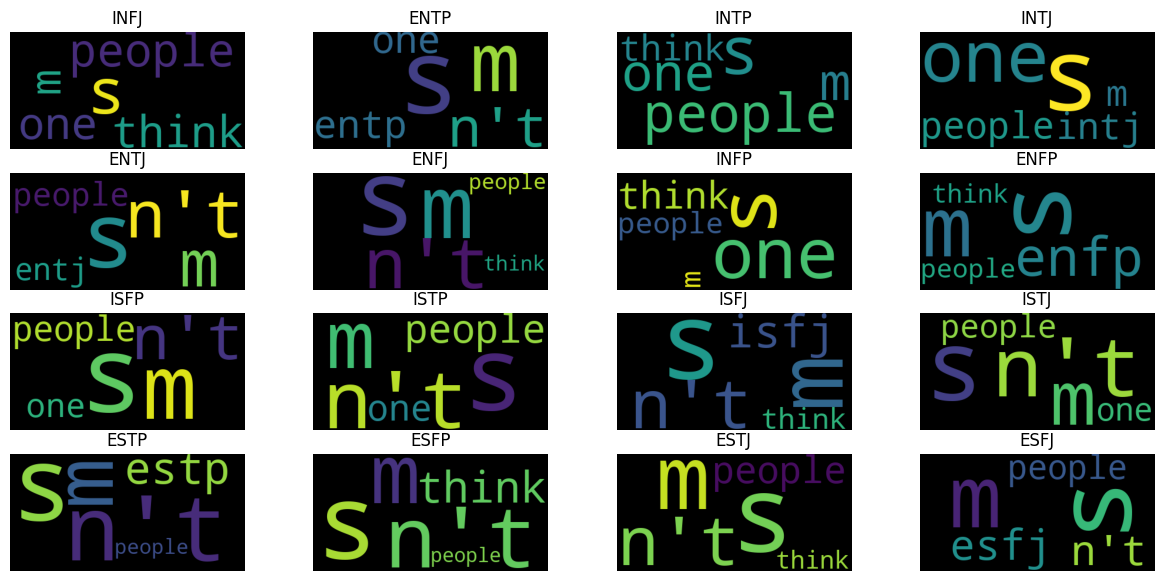

In [71]:
types = online_posts_df_merged["type"].unique()

fig = plt.figure(figsize=(15,7))

for i in range(len(types)):
    temp_df = online_posts_df_merged[online_posts_df_merged["type"] == types[i]]
    word_string = ""

    for index, row in temp_df.iterrows():
        word_string += " ".join([token for token in row["posts_no_url_tokenized_no_stop"]])

    word_cloud = wordcloud.WordCloud(max_words=5).generate(word_string)
    ax = fig.add_subplot(4,4,i+1)
    ax.set_title(types[i])
    ax.imshow(word_cloud)
    ax.axis("off")

plt.show()

Create word clouds for each of the perosnality axes

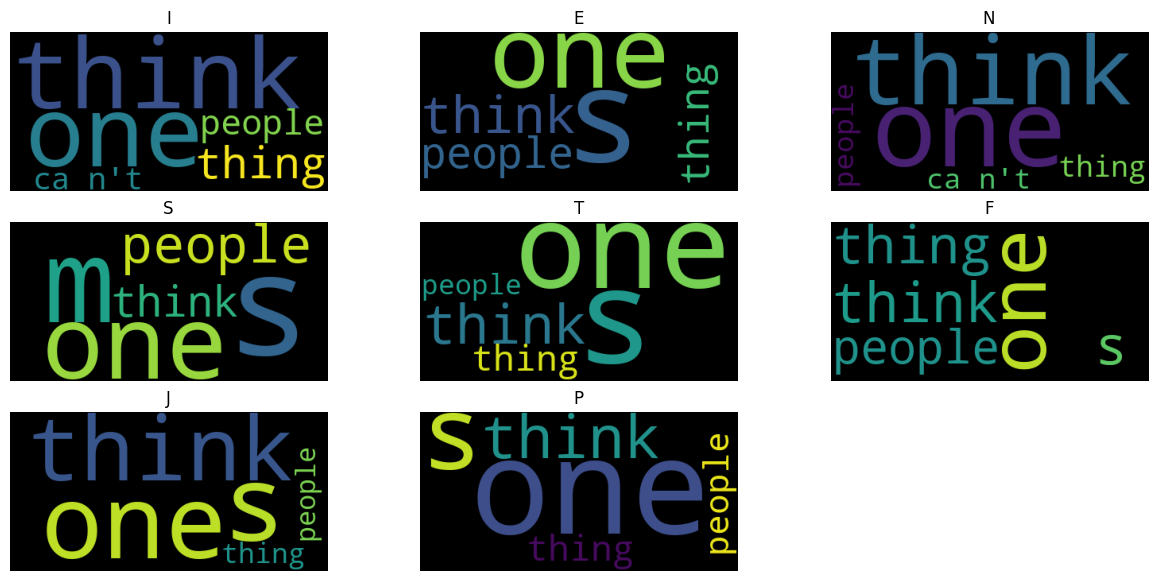

In [72]:
personality_axes_cols = ["I", "E", "N", "S", "T", "F", "J", "P"]

fig = plt.figure(figsize=(15,7))

for factor in personality_axes_cols:
    if factor == "I" or factor == "E":
        temp_df = online_posts_df_merged[online_posts_df_merged["e_vs_i"] == factor]
        
    elif factor == "N" or factor == "S":
        temp_df = online_posts_df_merged[online_posts_df_merged["s_vs_n"] == factor]

    elif factor == "T" or factor == "F":
        temp_df = online_posts_df_merged[online_posts_df_merged["t_vs_f"] == factor]

    elif factor == "J" or factor == "P":
        temp_df = online_posts_df_merged[online_posts_df_merged["j_vs_p"] == factor] 
        
    word_string = ""
    for index, row in temp_df.iterrows():
        word_string += " ".join([token for token in row["posts_no_url_tokenized_no_stop"]])

    word_cloud = wordcloud.WordCloud(max_words=5).generate(word_string)
    i = personality_axes_cols.index(factor)
    ax = fig.add_subplot(3,3,i+1)
    ax.set_title(factor)
    ax.imshow(word_cloud)
    ax.axis("off")

plt.show()